In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from DataPreparation import DataPreparation
import warnings

In [4]:
pics = './images'

In [5]:
df = pd.read_csv('./data/balanced_dataframe.csv', index_col=None)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,...,fr_Nhpyrrole,fr_aldehyde,fr_amidine,fr_aryl_methyl,fr_benzene,fr_benzodiazepine,fr_diazo,fr_halogen,fr_hdrzine,label
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,9.103951,-0.051090,3.459112,1.375036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,9.103026,-0.051090,3.450909,1.367373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,9.103025,-0.051090,3.448581,1.360843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,5.825210,-0.051059,3.346646,1.323034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,9.101988,0.552888,3.020157,1.976391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [108]:
X = df.drop(columns=['label'])
y = df['label']

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )
y_test.value_counts()

0    915
1    915
Name: label, dtype: int64

In [110]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)

# # get scaled clean data
# # use StandartScaler
X_train, X_test, y_train, y_test = data_preparation.clean_dataset()

Index(['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'SPS',
       'MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW',
       'BCUT2D_CHGHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
       'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA2', 'PEOE_VSA3',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA8', 'SMR_VSA2', 'SMR_VSA3',
       'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
       'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5',
       'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA5',
       'VSA_EState1', 'VSA_EState6', 'VSA_EState7', 'NumAliphaticCarbocycles',
       'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumHeteroatoms',
       'NumRotatableBonds', 

In [111]:
X.shape

(6100, 112)

In [112]:
#X_train[[0, 1]].set_axis(['one', 'two'], axis=1)

In [113]:
lr = LogisticRegression(max_iter=200)
scoring_lr = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid_lr = {'C': [0.01, 0.1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
warnings.filterwarnings('ignore')
grid_lr = GridSearchCV(lr, 
                    param_grid_lr, 
                    cv=cv_lr, 
                    scoring=scoring_lr, 
                    refit='AUC', 
                    verbose=1, 
                    n_jobs=-1,
                    # error_score='raise'
                    )

%time grid_lr.fit(X_train, y_train)

print()
print(grid_lr.best_params_)

y_pred = grid_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 5.54 s, sys: 4.92 s, total: 10.5 s
Wall time: 18.2 s

{'C': 100, 'solver': 'newton-cg'}
Accuracy: 0.9448087431693989
Mean ROC AUC: 0.9448087431693989


In [114]:
y_pred = grid_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("For test set:")

print(classification_report(y_test, y_pred))

For test set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       915
           1       0.93      0.96      0.95       915

    accuracy                           0.94      1830
   macro avg       0.95      0.94      0.94      1830
weighted avg       0.95      0.94      0.94      1830



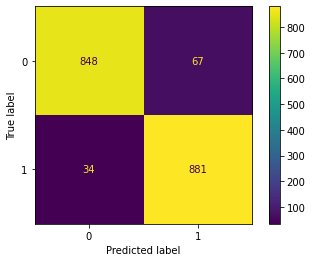

In [115]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_lr.classes_)
disp.plot()
plt.show()

In [116]:
y_pred = grid_lr.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
print("For train set:")

print(classification_report(y_train, y_pred))

For train set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2135
           1       0.94      0.96      0.95      2135

    accuracy                           0.95      4270
   macro avg       0.95      0.95      0.95      4270
weighted avg       0.95      0.95      0.95      4270



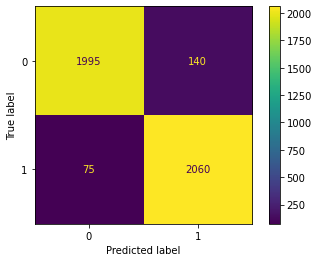

In [117]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_lr.classes_)
disp.plot()
plt.show()

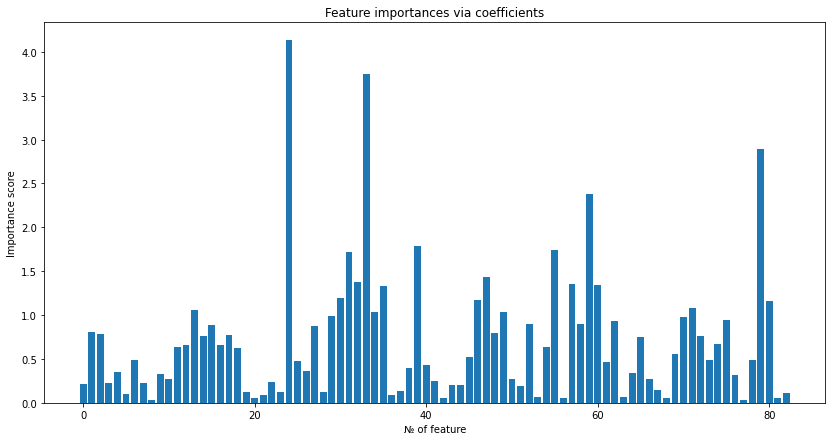

In [118]:
# ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(clf.coef_)
feature_names = X_train.columns
plt.figure(figsize=(14,7))
plt.bar(height=importance[0], x=feature_names)
plt.title("Feature importances via coefficients")
plt.xlabel('№ of feature')
plt.ylabel('Importance score')
plt.show()

<AxesSubplot:ylabel='Feature'>

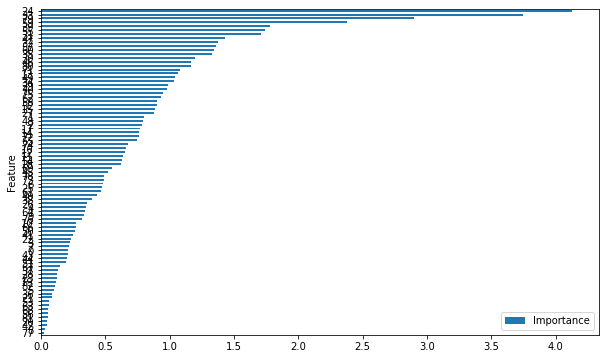

/home/almaz/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/almaz/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/almaz/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/almaz/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached 

In [119]:
avg_importance = np.mean(np.abs(clf.coef_), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## After feature selection N = 20

In [79]:
clmns_sel = ['PEOE_VSA13',
    'Chi3v',
    'FpDensityMorgan3',
    'Kappa1',
    'BertzCT',
    'EState_VSA3',
    'SMR_VSA4',
    'BCUT2D_LOGPLOW',
    'Chi2n',
    'qed',
    'EState_VSA11',
    'BCUT2D_MWHI',
    'MinPartialCharge',
    'MinAbsEStateIndex',
    'SMR_VSA2',
    'SlogP_VSA3',
    'Kappa3',
    'MaxPartialCharge',
    'SlogP_VSA1',
    'PEOE_VSA3' ]
R = X[clmns_sel]
R

,PEOE_VSA13,Chi3v,FpDensityMorgan3,Kappa1,BertzCT,EState_VSA3,SMR_VSA4,BCUT2D_LOGPLOW,Chi2n,qed,EState_VSA11,BCUT2D_MWHI,MinPartialCharge,MinAbsEStateIndex,SMR_VSA2,SlogP_VSA3,Kappa3,MaxPartialCharge,SlogP_VSA1,PEOE_VSA3
0,15.929944,24.793308,9.103951,30.960622,0.000000,4.0,20.939096,3.068350e+07,17.696186,23.375000,1.0,-0.051090,10.123678,-1.272753,17.475505,0.116048,40.759436,79.918731,13.782540,0.000000
1,15.929944,24.793308,9.103026,30.960622,0.000000,4.0,20.939096,3.001086e+07,23.762553,23.375000,1.0,-0.051090,10.124302,-1.271941,11.828328,0.117146,40.759436,79.918731,13.772163,0.000000
2,15.929944,24.793308,9.103025,30.960622,0.000000,4.0,20.939096,2.989174e+07,17.696186,23.375000,1.0,-0.051090,10.124439,-1.271281,11.828328,0.117998,40.759436,79.918731,13.773383,0.000000
3,0.000000,20.056445,5.825210,56.643908,0.000000,3.0,12.841643,3.243335e+07,48.794463,25.218750,1.0,-0.051059,9.897992,-1.235039,5.817863,0.553914,41.216776,16.562573,7.108612,0.000000
4,27.530884,4.417151,9.101988,6.420822,0.000000,3.0,28.935581,1.167653e+05,45.758864,12.285714,1.0,0.552888,10.103988,0.226017,5.948339,0.898357,51.150887,79.918731,6.271772,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,11.336786,0.000000,7.218019,27.315968,5.559267,3.0,15.780072,1.688028e+05,30.537829,11.304348,1.0,0.492694,10.208623,-0.411430,11.477173,0.579532,50.667004,32.133549,2.264240,12.841643
6096,0.000000,18.221247,7.926766,19.889315,0.000000,0.0,5.697039,2.721476e+05,13.847474,29.375000,0.0,-0.845814,10.227966,-3.541177,5.907180,-0.018440,22.375235,32.233449,27.154937,0.000000
6097,11.600940,19.428958,6.324554,45.572602,5.907180,2.0,57.680175,1.193943e+08,38.821852,22.542857,0.0,-0.667596,9.704724,-0.204735,29.189097,1.136124,40.369838,35.495692,5.237276,25.180371
6098,11.761885,14.325937,8.000113,17.330112,0.000000,2.0,24.725238,4.473418e+06,19.056471,18.250000,1.0,-0.126220,10.296962,-0.464767,11.938294,0.505647,30.331835,32.166684,7.406409,0.000000


In [80]:
X_train, X_test, y_train, y_test = train_test_split(R, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )

In [81]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = data_preparation.clean_dataset()

Index(['PEOE_VSA13', 'Chi3v', 'FpDensityMorgan3', 'Kappa1', 'BertzCT',
       'EState_VSA3', 'SMR_VSA4', 'BCUT2D_LOGPLOW', 'Chi2n', 'qed',
       'EState_VSA11', 'BCUT2D_MWHI', 'MinPartialCharge', 'MinAbsEStateIndex',
       'SMR_VSA2', 'SlogP_VSA3', 'PEOE_VSA3'],
      dtype='object')


### Only 17 features left after cleaning

In [86]:
from sklearn.linear_model import LogisticRegressionCV
cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
lr = LogisticRegressionCV(cv=cv_lr,Cs=[100], solver='newton-cg',max_iter=200).fit(X_train, y_train)

In [91]:
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("For test set:")

print(classification_report(y_test, y_pred))

For test set:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       915
           1       0.87      0.89      0.88       915

    accuracy                           0.88      1830
   macro avg       0.88      0.88      0.88      1830
weighted avg       0.88      0.88      0.88      1830



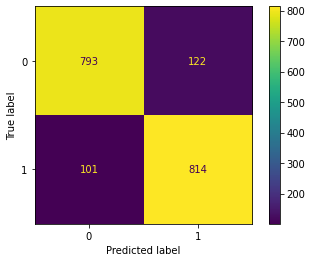

In [92]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()

In [93]:
y_pred = lr.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
print("For train set:")

print(classification_report(y_train, y_pred))

For train set:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2135
           1       0.87      0.89      0.88      2135

    accuracy                           0.88      4270
   macro avg       0.88      0.88      0.88      4270
weighted avg       0.88      0.88      0.88      4270



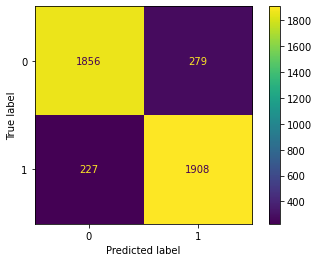

In [94]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()